# Seasonality analysis

In [57]:
import os
import datetime as dt


import pandas as pd
from pandas_datareader import data as pdr

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import MSTL

from IPython.display import display, Markdown

import requests_cache
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter



class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass





# select the symbol to analyze

# symbol = '2B7K.DE'    # iShares MSCI World SRI UCITS ETF EUR (Acc)
# symbol = 'EUNL.DE'    # iShares Core MSCI World UCITS ETF USD (Acc)
# symbol = 'EURUSD=X'   # USD/EUR
# symbol = 'GBPUSD=X'   # GBP/USD
# symbol = 'AUDUSD=X'   # AUD/USD
# symbol = '^ATX'       # Austrian Traded Index in EUR
# symbol = 'ALV.DE'     # Allianz SE
# symbol = 'ADS.DE'     # adidas AG
# symbol = 'EBAY'       # eBay Inc.
# symbol = 'AXP'        # American Express Company
# symbol = 'BTC-USD'    # Bitcoin USD
# symbol = 'ETH-USD'    # Ethereum USD
symbol = '^GSPC'    # S&P 500




# set maximum number of years to analyze
max_num_of_years = 30



# show seasonality in % instead of currency
seasonalityInPercent = True




def D(text: str):
    display(Markdown(text))






D('## Analysis configuration:')
D(f'* **Symbol selected**: {symbol}')
D(f'* **Max years to analyse**: {dt.date.today().year-1} until earliest {dt.date.today().year-max_num_of_years}')


## Analysis configuration:

* **Symbol selected**: ^GSPC

* **Max years to analyse**: 2022 until earliest 1993

In [58]:
dirname = '.downloads'
historyFilename = f'{dirname}{os.path.sep}{symbol}_{dt.date.today()}.csv'
cacheFilename = f"{dirname}{os.path.sep}yfinance.cache"

os.makedirs(dirname, exist_ok=True)


session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*5),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket),
    backend=SQLiteCache(cacheFilename),
)
ticker = yf.Ticker(symbol, session=session)
df = ticker.history(period='max')

if not os.path.isfile(historyFilename):
    yf.pdr_override()  # <== that's all it takes :-)
    df = pdr.get_data_yahoo(tickers=[symbol], interval="1d")[['Close']]
    df.to_csv(historyFilename)
else:
    df = pd.read_csv(historyFilename, parse_dates=['Date'], index_col=['Date'])




D('## Data loaded:')
D(f'* Close prices of symbol _{symbol}_')
D(f'* From {df.index.min().strftime("%d.%m.%y")} to {df.index.max().strftime("%d.%m.%y")}')

#for (k, v) in ticker.info.items():
#    D(f'* {k}: {v}')

D('## Statistics:')
print(df.describe())
D('## Data:')
print(df)

## Data loaded:

* Close prices of symbol _^GSPC_

* From 30.12.27 to 30.06.23

## Statistics:

              Close
count  23989.000000
mean     588.309525
std      935.591103
min        4.400000
25%       24.459999
50%      101.470001
75%      967.000000
max     4796.560059


## Data:

                  Close
Date                   
1927-12-30    17.660000
1928-01-03    17.760000
1928-01-04    17.719999
1928-01-05    17.549999
1928-01-06    17.660000
...                 ...
2023-06-26  4328.819824
2023-06-27  4378.410156
2023-06-28  4376.859863
2023-06-29  4396.439941
2023-06-30  4450.379883

[23989 rows x 1 columns]


In [59]:
rolling_resolution = 200

df.index = pd.to_datetime(df.index)
df = df.asfreq('d')                 # set correct frequency
df = df.fillna(method='ffill')      # fill up missing values

annualDf = pd.DataFrame()
numOfYears = 0
for year in sorted(list(set(df.index.year)), reverse=True)[1:-1]:
    numOfYears += 1
    if numOfYears > max_num_of_years:
        break
    curYearValues = df[str(year) + '-01-01':str(year) + '-12-31']['Close'].values
    if curYearValues.size == 366:
        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
    annualDf[str(year)] = curYearValues

resultMean = annualDf.mean(axis=1)
resultMin = annualDf.min(axis=1)
resultMax = annualDf.max(axis=1)
annualDf['mean'] = resultMean
annualDf['min'] = resultMin
annualDf['max'] = resultMax

lastYear = dt.date.today().year-1
range = pd.date_range(str(lastYear) + '-01-01', str(lastYear) + '-12-31', freq='D')
annualDf['date'] = range
annualDf = annualDf.set_index('date')

# annualDf.index = resultDf.index.strftime('%d. %b')

D('## Initial data overview')
annualDf

## Initial data overview

,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,...,1999,1998,1997,1996,1995,1994,1993,mean,min,max
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,4766.180176,3756.070068,3230.780029,2506.850098,2673.610107,2238.830078,2043.939941,2058.899902,1848.359985,1426.189941,...,1229.229980,970.429993,740.739990,615.929993,459.269989,466.450012,435.709991,1575.909347,435.709991,4766.180176
2022-01-02,4766.180176,3756.070068,3257.850098,2510.030029,2695.810059,2238.830078,2043.939941,2058.199951,1831.979980,1462.420044,...,1229.229980,975.039978,737.010010,620.729980,459.269989,466.450012,435.709991,1578.575352,435.709991,4766.180176
2022-01-03,4796.560059,3756.070068,3234.850098,2447.889893,2713.060059,2257.830078,2043.939941,2058.199951,1831.369995,1459.369995,...,1229.229980,975.039978,748.030029,621.320007,459.109985,465.440002,435.709991,1581.620340,435.709991,4796.560059
2022-01-04,4793.540039,3700.649902,3234.850098,2531.939941,2723.989990,2270.750000,2012.660034,2058.199951,1831.369995,1466.469971,...,1228.099976,975.039978,748.030029,617.700012,460.709991,466.890015,435.380005,1579.412664,435.380005,4793.540039
2022-01-05,4700.580078,3726.860107,3234.850098,2531.939941,2743.149902,2269.000000,2016.709961,2020.579956,1831.369995,1466.469971,...,1244.780029,977.070007,748.030029,616.710022,460.339996,467.549988,434.339996,1576.475338,434.339996,4700.580078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,3829.250000,4791.189941,3703.060059,3240.020020,2488.830078,2682.620117,2268.879883,2060.989990,2088.770020,1841.400024,...,1457.099976,1226.270020,936.460022,756.789978,614.530029,462.470001,470.540009,1689.381012,462.470001,4791.189941
2022-12-28,3783.219971,4786.350098,3735.360107,3240.020020,2485.739990,2687.540039,2249.919922,2056.500000,2088.770020,1841.400024,...,1457.660034,1225.489990,936.460022,756.789978,614.119995,460.859985,470.940002,1687.658679,460.859985,4786.350098
2022-12-29,3849.280029,4793.060059,3727.040039,3240.020020,2485.739990,2673.610107,2249.260010,2078.360107,2090.570068,1841.400024,...,1463.459961,1241.810059,953.349976,756.789978,615.929993,461.170013,470.579987,1691.437351,461.170013,4793.060059


In [60]:
periods = [4, 12, 52, 365]
periodNames = ['seasonal_' + str(i) for i in periods]

decompose = MSTL(df['Close'], periods=periods)
decompose = decompose.fit()

numOfYears = 0
retDf = pd.DataFrame()
for year in sorted(list(set(decompose.seasonal[periodNames[3]].index.year)), reverse=True)[1:-1]:
    numOfYears += 1
    if numOfYears > max_num_of_years:
        break
    curYearValues = decompose.seasonal[periodNames[3]][str(year) + '-01-01':str(year) + '-12-31'].values
    if curYearValues.size == 366:
        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
    annualDf[periodNames[3] + '_' + str(year)] = curYearValues

D('## Seasonal decomposition')
annualDf

## Seasonal decomposition

,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,...,seasonal_365_2002,seasonal_365_2001,seasonal_365_2000,seasonal_365_1999,seasonal_365_1998,seasonal_365_1997,seasonal_365_1996,seasonal_365_1995,seasonal_365_1994,seasonal_365_1993
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,4766.180176,3756.070068,3230.780029,2506.850098,2673.610107,2238.830078,2043.939941,2058.899902,1848.359985,1426.189941,...,13.927063,13.349411,11.619953,10.706326,9.245959,7.404863,4.386260,2.163919,0.041365,-1.819191
2022-01-02,4766.180176,3756.070068,3257.850098,2510.030029,2695.810059,2238.830078,2043.939941,2058.199951,1831.979980,1462.420044,...,13.491044,12.819540,12.493555,11.315559,9.686846,7.719202,5.226610,2.878206,0.619683,-1.367218
2022-01-03,4796.560059,3756.070068,3234.850098,2447.889893,2713.060059,2257.830078,2043.939941,2058.199951,1831.369995,1459.369995,...,12.932339,12.721615,11.839900,10.506107,8.753297,6.697438,5.467923,3.107667,0.866190,-1.088036
2022-01-04,4793.540039,3700.649902,3234.850098,2531.939941,2723.989990,2270.750000,2012.660034,2058.199951,1831.369995,1466.469971,...,14.448970,13.928002,12.212472,11.177662,9.473083,7.264725,4.420766,2.116625,0.036110,-1.649006
2022-01-05,4700.580078,3726.860107,3234.850098,2531.939941,2743.149902,2269.000000,2016.709961,2020.579956,1831.369995,1466.469971,...,12.109642,11.822812,13.094833,11.810384,9.951738,7.586483,4.765187,2.226571,-0.053786,-1.835722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,3829.250000,4791.189941,3703.060059,3240.020020,2488.830078,2682.620117,2268.879883,2060.989990,2088.770020,1841.400024,...,9.178660,9.032859,8.678485,6.843540,5.899723,4.490824,2.858545,1.043481,-0.718380,-2.238559
2022-12-28,3783.219971,4786.350098,3735.360107,3240.020020,2485.739990,2687.540039,2249.919922,2056.500000,2088.770020,1841.400024,...,10.057421,10.273171,10.187815,8.139962,7.272775,5.926330,4.297226,1.115473,-0.563539,-2.004073
2022-12-29,3849.280029,4793.060059,3727.040039,3240.020020,2485.739990,2673.610107,2249.260010,2078.360107,2090.570068,1841.400024,...,10.969779,11.135252,10.943951,9.850334,9.150574,7.952054,6.404387,2.478011,0.638104,-1.028809


In [61]:
monthlyDf = pd.DataFrame()
numOfYears = 0
for year in sorted(list(set(decompose.seasonal.index.year)), reverse=True)[1:-1]:
    numOfYears += 1
    if numOfYears > max_num_of_years:
        break
    curYearValues = decompose.seasonal[periodNames[3]][str(year) + '-01-01':str(year) + '-12-31'].resample('M').mean().values
    if curYearValues.size == 366:
        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
    monthlyDf[periodNames[3] + '_' + str(year)] = curYearValues


montlyMean = monthlyDf.mean(axis=1)
monthlyStd = monthlyDf.std(axis=1)
monthlyMax = monthlyDf.max(axis=1)
monthlyDf['mean'] = montlyMean
monthlyDf['std'] = monthlyStd

monthlyDf['meanPositive'] = monthlyDf['mean'] > 0

range = pd.date_range(str(lastYear) + '-01-01', str(lastYear) + '-12-31', freq='M')
monthlyDf['date'] = range
monthlyDf = monthlyDf.set_index('date')
monthlyDf.index = monthlyDf.index.strftime('%b')

D('## Monthly mean')
monthlyDf

## Monthly mean

,seasonal_365_2022,seasonal_365_2021,seasonal_365_2020,seasonal_365_2019,seasonal_365_2018,seasonal_365_2017,seasonal_365_2016,seasonal_365_2015,seasonal_365_2014,seasonal_365_2013,...,seasonal_365_1999,seasonal_365_1998,seasonal_365_1997,seasonal_365_1996,seasonal_365_1995,seasonal_365_1994,seasonal_365_1993,mean,std,meanPositive
date,,,,,,,,,,,,,,,,,,,,,
Jan,48.862955,43.469447,37.109273,32.431570,27.962760,23.645156,18.870728,14.541594,9.816256,4.357694,...,8.642106,7.375276,5.435757,3.248845,1.034255,-0.903282,-2.349254,11.840812,13.526239,True
Feb,45.008506,39.741756,34.963921,31.750380,26.699092,21.771500,16.915446,13.000788,7.626314,1.824623,...,3.982365,3.896999,3.388322,3.064428,3.143655,3.331273,3.549711,7.441023,14.591149,True
Mar,-65.412747,-58.138401,-51.199658,-45.057499,-39.018684,-33.351689,-27.946869,-22.885118,-17.477337,-11.479843,...,3.765275,4.576525,4.742205,4.782617,4.882331,5.192315,5.370056,-12.516485,20.615282,False
Apr,-9.273800,-7.603580,-5.863385,-4.303737,-2.923934,-1.739897,-0.724196,-0.569979,0.552353,2.578174,...,6.183407,6.031889,5.787192,5.374625,4.625615,3.878492,3.036098,4.852112,6.730743,True
May,-43.541598,-37.554036,-31.720659,-25.605824,-20.110693,-14.786072,-9.564267,-3.547831,1.951278,8.016914,...,10.964934,10.213946,9.856696,9.395745,8.555261,7.351911,6.024071,4.204622,18.913948,True
Jun,-13.041007,-11.953021,-10.961532,-10.948290,-10.018197,-9.127240,-8.177118,-6.993841,-5.251024,-2.490822,...,13.331346,12.725727,12.363769,11.810274,10.778534,9.681285,8.587193,4.068338,10.028539,True
Jul,-10.969252,-8.059266,-5.457160,-3.724970,-1.456005,0.740743,2.895556,4.239434,6.364852,8.232734,...,8.362158,8.916774,9.844930,10.780254,11.482804,11.392188,10.594534,3.974810,5.852876,True
Aug,75.979742,67.525499,59.414121,51.340620,43.852937,36.571321,29.452423,22.417001,15.665472,9.073204,...,-5.955475,-5.084211,-3.585197,-2.035266,0.004067,1.142406,1.939053,11.306959,24.948013,True
Sep,-26.424574,-24.402583,-22.430667,-16.424226,-14.795623,-12.980960,-11.014139,-7.068943,-5.597357,-4.518224,...,-20.003374,-19.818071,-18.585392,-16.678291,-14.050856,-11.472582,-8.787639,-13.629377,5.920422,False


<Axes: title={'center': 'Annual monthly mean performance'}, xlabel='date', ylabel='USD'>

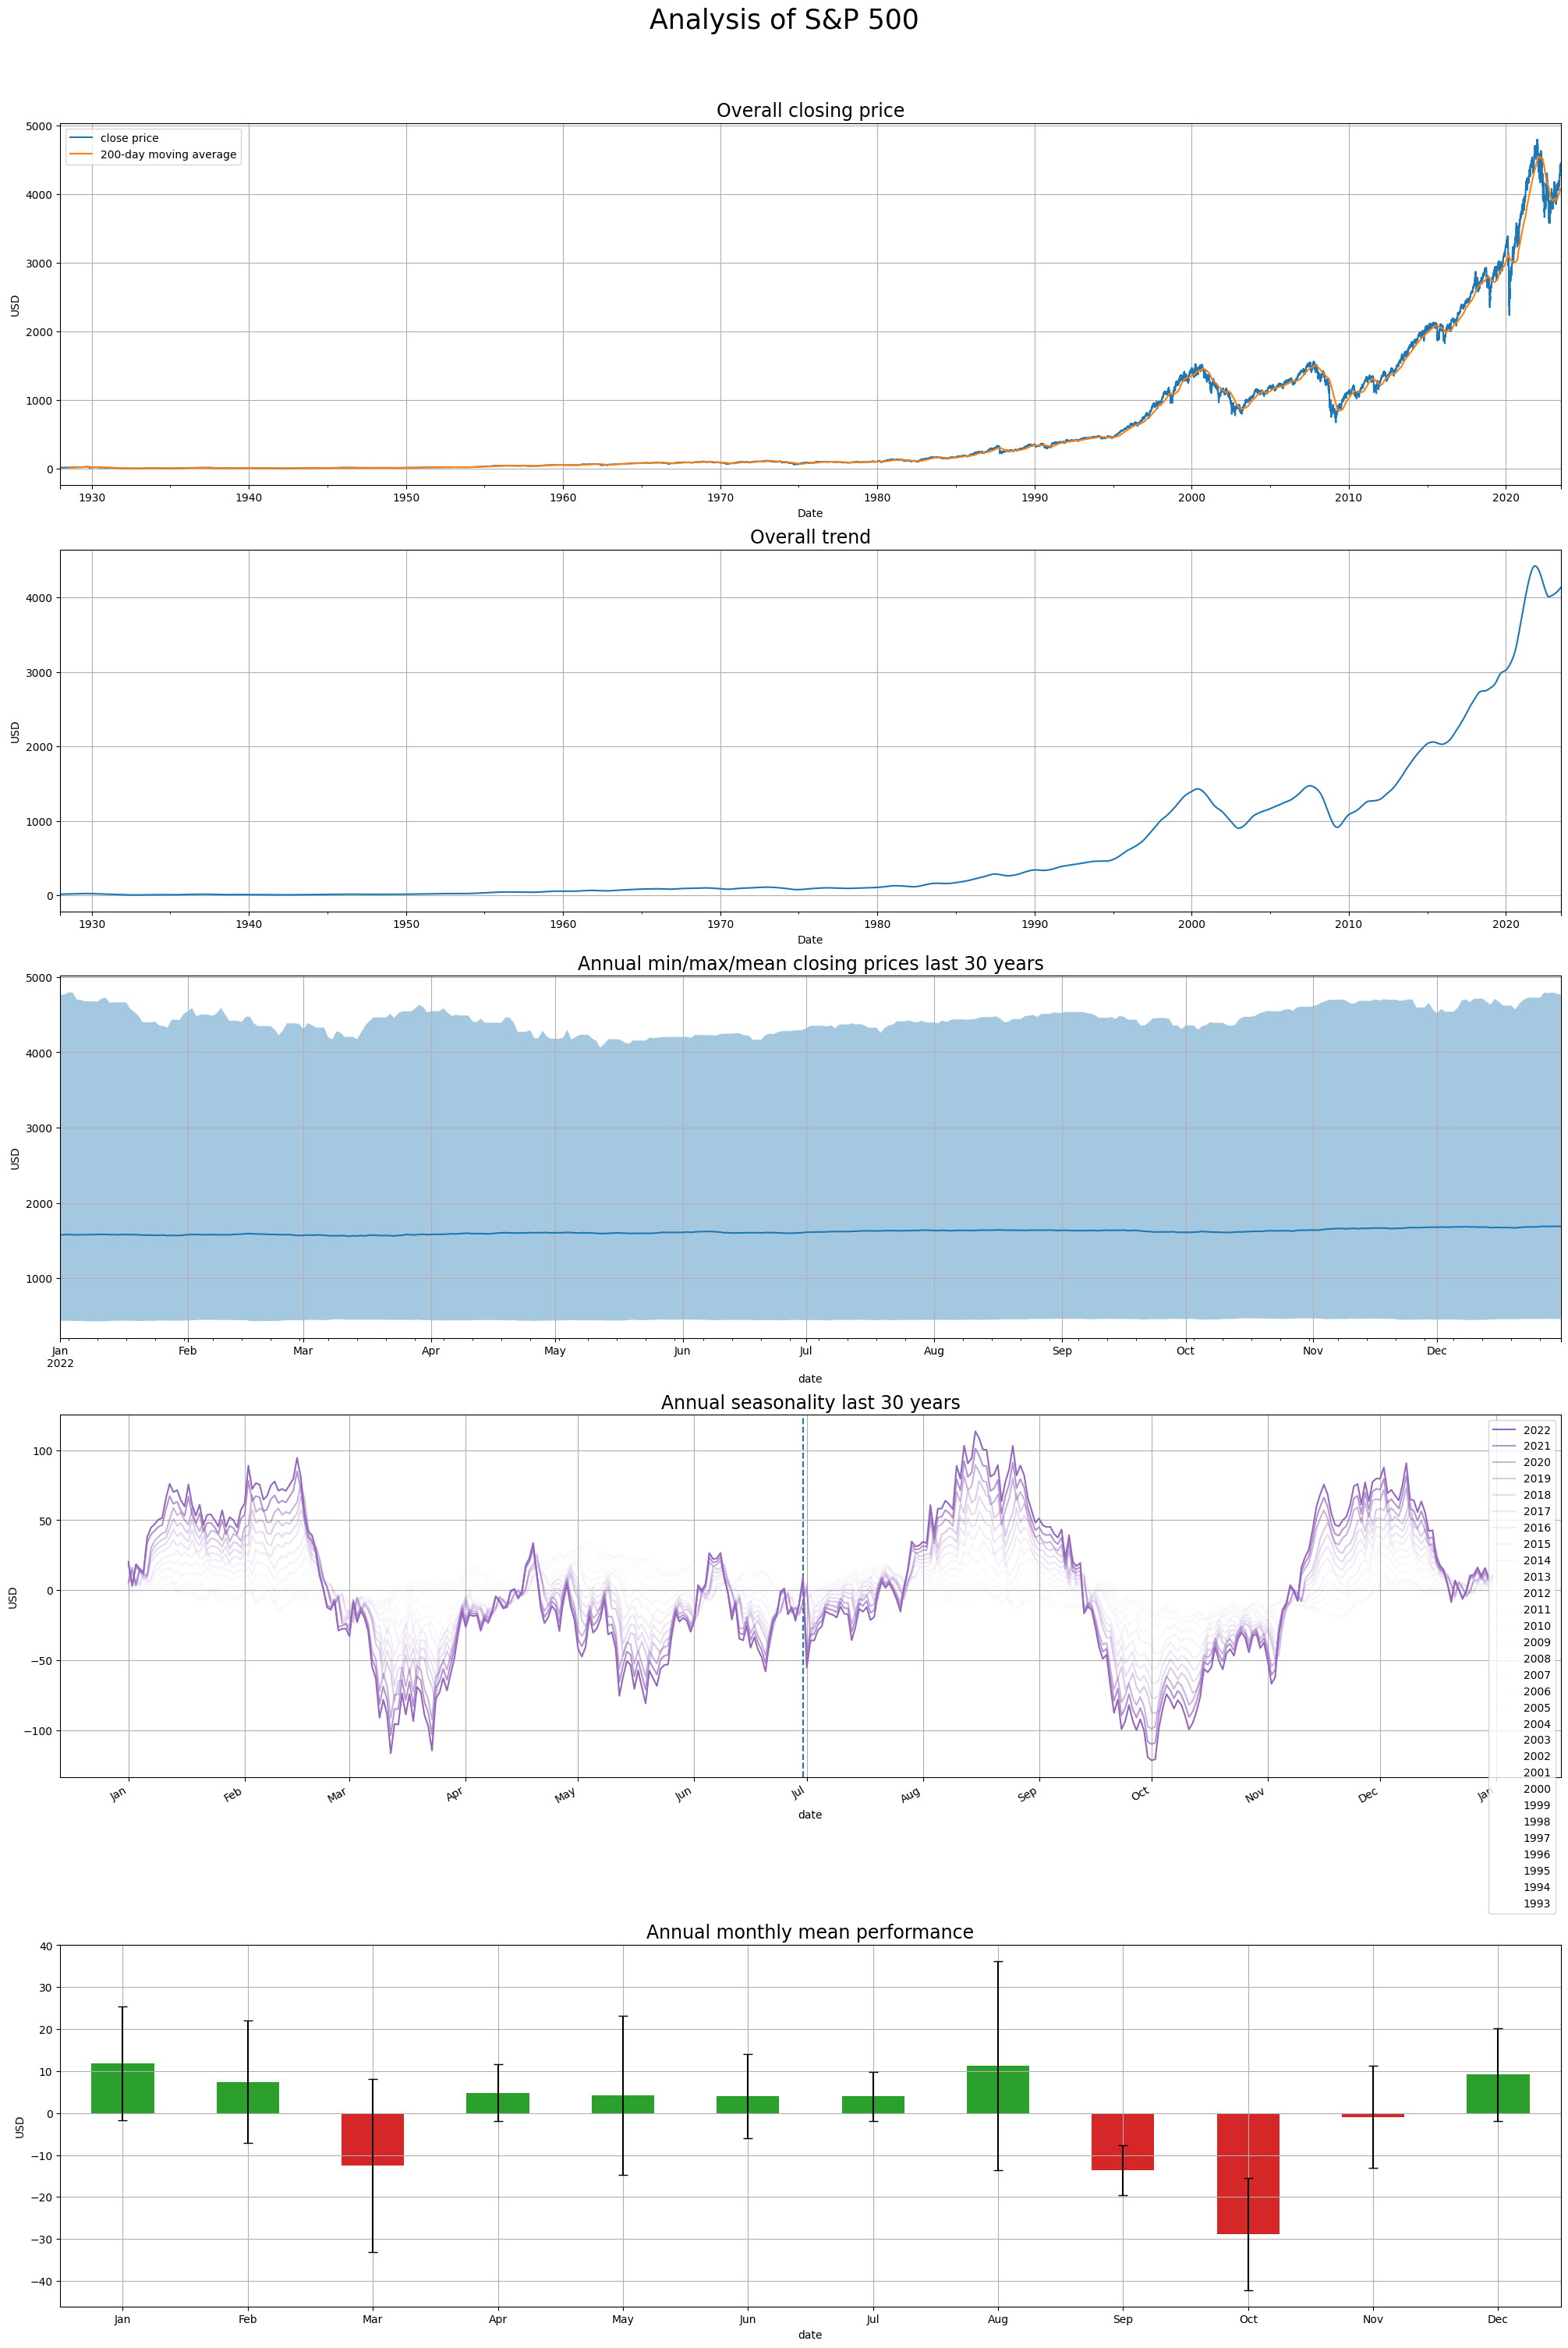

In [62]:
plt.figure(figsize=(20, 30), layout='constrained')
plt.suptitle(f'Analysis of {ticker.info["longName"]}\n\n', fontsize=25)

plt.subplot(511)
plt.title('Overall closing price', fontsize=17)
plt.ylabel(ticker.info['currency'])
df['Close'].plot(legend=True, label='close price')
df['Close'].rolling(rolling_resolution).mean().plot(legend=True, label=str(rolling_resolution) + '-day moving average', grid=True)

plt.subplot(512)
plt.title('Overall trend', fontsize=17)
plt.ylabel(ticker.info['currency'])
decompose.trend.plot(grid=True)

plt.subplot(513)
plt.title(f'Annual min/max/mean closing prices last {max_num_of_years} years', fontsize=17)
plt.fill_between(annualDf.index, annualDf['min'], annualDf['max'], alpha=0.4)
plt.ylabel(ticker.info['currency'])
annualDf['mean'].plot(grid=True)

plt.subplot(514)
plt.title(f'Annual seasonality last {max_num_of_years} years', fontsize=17)
plt.axvline(mdates.date2num(dt.datetime(lastYear, dt.date.today().month, dt.date.today().day)), linestyle='dashed')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
if seasonalityInPercent:
    plt.ylabel('%')
else:
    plt.ylabel(ticker.info['currency'])
alpha_value = 1
for col in annualDf.columns:
    if col.startswith(periodNames[3]):
        if seasonalityInPercent:
            usedAnnualDf = 100 * (annualDf[col] - annualDf[col].iloc[0]) / (annualDf[col].max() - annualDf[col].iloc[0])
        else:
            usedAnnualDf = annualDf[col]
        usedAnnualDf.plot(legend=True, label=col[-4:], color='tab:purple', alpha=alpha_value, grid=True)
        alpha_value = alpha_value * 0.7

plt.subplot(515)
plt.title('Annual monthly mean performance', fontsize=17)
plt.ylabel(ticker.info['currency'])
monthlyDf['mean'].plot(kind='bar', yerr=monthlyDf['std'], capsize=4, color=monthlyDf['meanPositive'].map({True: 'tab:green', False: 'tab:red'}), grid=True, rot=0)